# Project Description

**Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.**

### Data description

- Technological process
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate — promoter or flotation activator;
- Sulphate — sodium sulphide for this particular process;
- Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate
- Parameters of stages
- air amount — volume of air
> fluid levels
- feed size — feed particle size
- feed rate
- Feature naming
> Here's how you name the features:
[stage].[parameter_type].[parameter_name]
- Example: rougher.input.feed_ag

Possible values for [stage]:
- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics

Possible values for [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

### Project instructions
**1. Prepare the data**
>1.1. Open the files and look into the data.

Path to files:
- /datasets/gold_recovery_train.csv
- /datasets/gold_recovery_test.csv
- /datasets/gold_recovery_full.csv
>1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
- 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
- 1.4. Perform data preprocessing.

**2. Analyze the data**
- 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
- 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
- 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

**3. Build the model**
- 3.1. Write a function to calculate the final sMAPE value.
- 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [1]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import plotly.express as px
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
#Load our data sets

train_gold = pd.read_csv('gold_recovery_train.csv',parse_dates=True, infer_datetime_format=True, index_col='date')
test_gold = pd.read_csv('gold_recovery_test.csv',parse_dates=True, infer_datetime_format=True, index_col='date')
gold = pd.read_csv('gold_recovery_full.csv',parse_dates=True, infer_datetime_format=True, index_col='date')

In [3]:
#Creating auxiliary functions
def miss_dup(data):
    print('Number of missing values in our data set:')
    print(data.isnull().sum())
    print()
    print('Number of duplicates in our data set:',data.duplicated().sum())

def show(data):
    print(data.info())
    print(data.describe())
    return data.sample(5)

In [4]:
#Checking what we have in our first data set
miss_dup(train_gold)

Number of missing values in our data set:
final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

Number of duplicates in our data set: 16


In [5]:
show(train_gold)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2018-06-13 11:59:59,3.933171,11.037830,6.727559,46.584006,71.990753,8.408016,2.214375,8.849677,1.783123,117.857821,...,30.036057,-498.009592,21.999658,-499.286046,24.976691,-499.249768,22.975138,-499.820789,24.983096,-498.463790
2018-06-17 21:59:59,4.202885,11.905214,6.588792,44.883515,68.642465,8.689283,2.607623,8.498022,1.952054,122.647609,...,27.038589,-520.414523,19.950427,-505.400002,18.034822,-500.250197,13.946934,-500.658487,13.994784,-505.467464
2017-07-01 11:59:59,5.375617,10.588572,7.620606,44.205162,61.719110,7.383858,2.493139,9.794236,2.320480,78.865157,...,18.036871,-500.472403,13.073268,-380.856101,17.993268,-500.001596,13.007624,-500.003411,14.998399,-499.977553
2018-07-02 19:59:59,3.480208,10.644975,6.703221,46.822778,70.860520,9.480069,2.483251,7.199623,1.954294,150.415117,...,24.964864,-501.284085,19.988674,-490.339954,18.041361,-500.319412,13.004280,-499.862491,13.004848,-500.764734
2017-01-11 19:59:59,4.129018,8.477903,13.136784,47.539575,62.695083,9.589116,3.322181,8.742148,3.633205,159.775168,...,13.974238,-500.768560,12.950424,-502.403833,14.425194,-499.858774,7.998419,-500.279371,20.014233,-600.411803


In [6]:
#Test data set
miss_dup(test_gold)

Number of missing values in our data set:
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.

In [7]:
#Test data set
show(test_gold)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-12-16 05:59:59,180.404185,12.534573,6.90,1.314723,1501.154848,-499.791830,1500.571708,-499.416245,1503.520134,-498.176195,...,16.985375,-499.419498,14.944268,-499.704772,17.708845,-499.674977,11.945038,-499.859014,20.990128,-499.068006
2016-09-04 00:59:59,123.453451,8.050887,6.92,0.904880,1302.435582,-500.408156,1300.168848,-500.103672,1301.050235,-499.246943,...,12.007272,-500.159876,8.015489,-501.293095,7.867156,-501.500565,5.014251,-499.312778,10.032089,-500.400000
2016-10-10 20:59:59,197.793527,8.904348,7.57,1.000186,1499.827287,-499.992905,1502.245528,-500.343388,1500.809131,-500.834675,...,11.884020,-499.161409,12.042152,-496.674319,9.634682,-498.702667,6.969744,-499.515473,17.032121,-499.443352
2017-09-24 22:59:59,173.544887,5.991566,6.75,1.995377,1382.868559,-514.756492,1389.776599,-492.415424,1417.896835,-466.746218,...,15.940271,-498.621680,14.020474,-399.398927,12.050062,-500.600790,10.007607,-499.969818,12.994775,-501.098551
2017-11-27 09:59:59,219.979518,10.990236,7.10,2.217427,1597.260746,-502.468480,1601.519426,-497.501162,1597.722042,-502.626042,...,16.990503,-499.319637,14.978610,-500.994776,10.949030,-500.034499,8.939711,-499.740242,15.987920,-498.922775


In [8]:
#Our main gold data set
miss_dup(gold)

Number of missing values in our data set:
final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

Number of duplicates in our data set: 22


In [9]:
#Main data set
show(gold)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 21:59:59,5.823118,6.695543,13.384066,46.296351,64.456032,9.840717,2.127796,11.360806,2.866964,115.052255,...,16.975544,-499.602404,15.027463,-499.683969,16.630406,-498.777019,8.084931,-495.247759,19.996770,-597.984965
2017-02-23 16:59:59,7.034332,10.241551,15.757617,42.534733,76.218580,12.813361,4.204774,8.973405,3.625497,175.664113,...,24.999752,-400.115006,22.847841,-399.906219,23.002410,-449.942230,20.005534,-450.165219,24.996731,-499.620288
2018-04-28 15:59:59,6.220393,11.318218,7.748058,42.778664,67.219417,9.400400,2.169416,8.155707,2.418241,135.540626,...,26.995301,-510.337995,19.935968,-510.656224,19.984671,-502.252039,15.004814,-500.330143,17.973927,-502.152217
2017-07-17 19:59:59,4.807913,9.806378,12.527713,45.180306,61.390046,7.484594,2.934978,10.977584,2.753560,114.109086,...,22.002065,-500.882572,17.975029,-380.246952,18.000946,-499.986920,15.004956,-500.303502,15.011453,-500.437680
2017-09-29 07:59:59,4.433671,12.400607,6.570356,45.121775,72.276698,6.301323,2.633066,10.798553,1.967797,147.215123,...,16.991237,-501.063986,14.970890,-404.589984,12.985436,-499.955157,10.983830,-500.186059,15.000727,-500.001374


> Coclusion: What we see from the previous step that we have in each variable missing values.Let's check if all alright with our **Target** variable **Recovery** by recalculating those values and check how they match with our recovery column in data set

**Step 1.2. Checking that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery**


>RECOVERY = ((C * (F - T)) / (F *( C - T))) * 100%

- C — share of gold in the concentrate right after flotation 
- F — share of gold in the feed before flotation 
- T — share of gold in the rougher tails right after flotation 

Here we need to calculate with our primary data set where we didn't clean our missing values it will provide to use better accuracy

In [10]:
def recovery(c,f,t):
    value = ((c * (f - t)) / (f * (c - t)))
    recovery = value * 100
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    return recovery


c = train_gold['rougher.output.concentrate_au']
f = train_gold['rougher.input.feed_au']
t = train_gold['rougher.output.tail_au']

recovery_val = recovery(c,f,t)
#And then I propose to reffill missing values of each of our variable by "0"
MAE_val = mae(train_gold['rougher.output.recovery'].fillna(0),recovery_val.fillna(0))
print('Our MAE number between recovery calculations and the feature values is equal to: {:.3}'.format(MAE_val))

Our MAE number between recovery calculations and the feature values is equal to: 7.88e-15


>Conclusion:  **MAE** of calcualted and provided data is very very close to zero. That means, we don't need to worry about errors in our data, because the provided data was correctly done!

**Step 1.3  Analyzing the features not available in the test set.**

In [11]:
#Creating a list with names of all features from our train data set
train_name = train_gold.columns.tolist()
#The same operation as we did prevous but for the test data set
test_name = test_gold.columns.tolist()
f
#Looping from all features in the test data set and comparing them with features in the train data set
features_not_test = []
for i in train_name:
    if i not in test_name:
        features_not_test.append(i)
print('Our features which no in Test set are:')
features_not_test

Our features which no in Test set are:


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

>Conclusion: We see that in our **test_gold** data set we don't have all output features that we have in the train set. They were intentionally removed. Because these columns have values that will cause data leakage for our future models.

**Step 1.4. Perform data preprocessing**


In [12]:
#prepare imputer for filling missing values
imputer =SimpleImputer()


#fit and fill missing values of training dataset using imputer
train_gold_upd = pd.DataFrame(imputer.fit_transform(train_gold))

#imputer removes column names and index, get them back
train_gold_upd.columns = train_gold.columns
train_gold_upd.index = train_gold.index


#use fitted imputer to fill missing values of source dataset
gold_upd = pd.DataFrame(imputer.transform(gold))
gold_upd.columns = gold.columns
gold_upd.index = gold.index

#get filled values for testing file from source
test_gold_upd = gold_upd.loc[test_gold.index,test_gold.columns]

> Conclusion: In the last steps, we filled using mean values of the training dataset. After all, the steps were done, we can say that we cleared and prepared our data sets for the next moves and can start working with them. 

### Step 2 Analyze the data

**Step 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.**

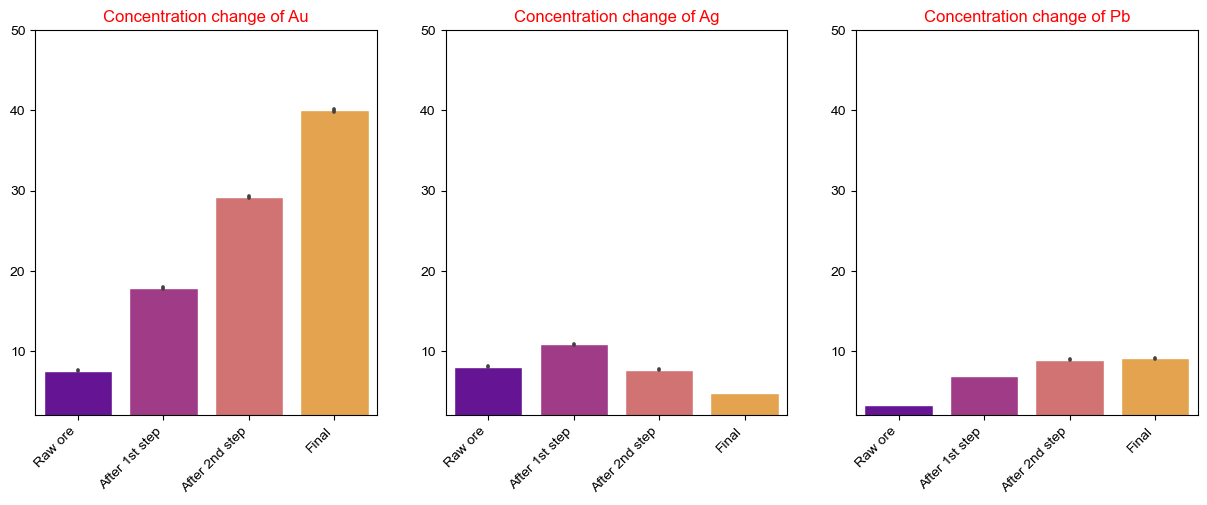

In [13]:
#columns showing each metals concentration at different stages

au_conc = ['rougher.input.feed_au','rougher.output.concentrate_au',
         'primary_cleaner.output.concentrate_au','final.output.concentrate_au']
ag_conc = ['rougher.input.feed_ag','rougher.output.concentrate_ag',
         'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
pb_conc = ['rougher.input.feed_pb','rougher.output.concentrate_pb',
         'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']

#using a for loop, prepare bar charts for the change of concentration of every metal at each stage
metals=[au_conc, ag_conc, pb_conc]
titles=['Concentration change of Au', 'Concentration change of Ag', 'Concentration change of Pb']

fig, ax = plt.subplots(1,3, figsize=(15, 5))
for i in range(3):
    sns.set_style('darkgrid')
    sns.barplot(data=gold_upd[metals[i]], ax=ax[i], palette='plasma')
    ax[i].set_xticklabels(labels=['Raw ore', 'After 1st step', 'After 2nd step', 'Final'], rotation=45, ha='right')
    ax[i].set_ylim(2, 50)
    ax[i].set_title(titles[i],color='r')

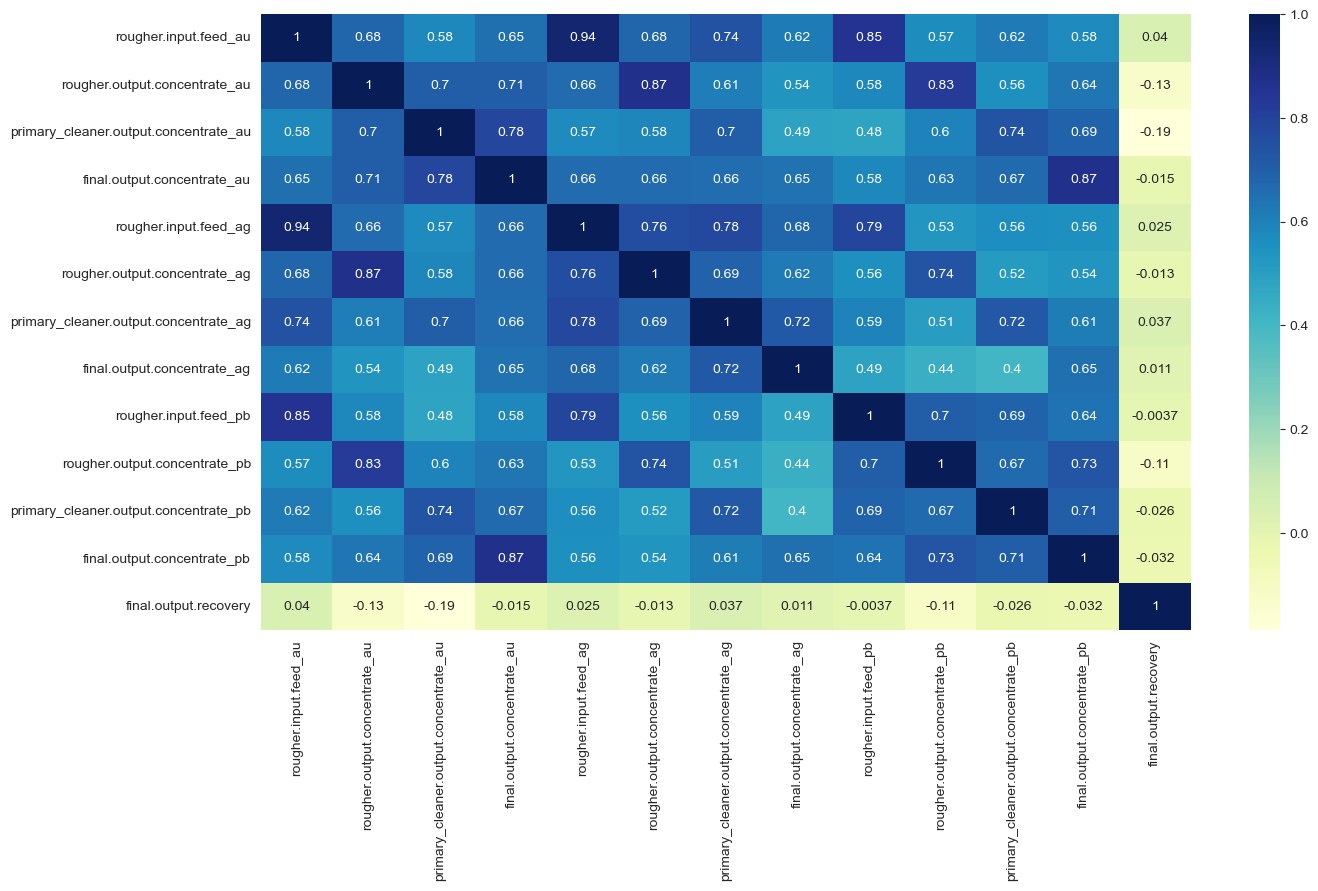

In [14]:
#Let's show what type of corraletion we have bettwen our  variables (Au, Ag, Pb) and final recovery output
corr_data = gold_upd[['rougher.input.feed_au','rougher.output.concentrate_au',
         'primary_cleaner.output.concentrate_au','final.output.concentrate_au','rougher.input.feed_ag','rougher.output.concentrate_ag',
         'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag','rougher.input.feed_pb','rougher.output.concentrate_pb',
         'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb','final.output.recovery']]
plt.figure(figsize=(15,8))
sns.heatmap(corr_data.corr(),annot=True, cmap='YlGnBu');


**Step 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.**

In [15]:
#Creating a new variables which will represent our necessary distribution
dist_train = train_gold_upd['rougher.input.feed_size'] 
dist_test = test_gold_upd['rougher.input.feed_size']

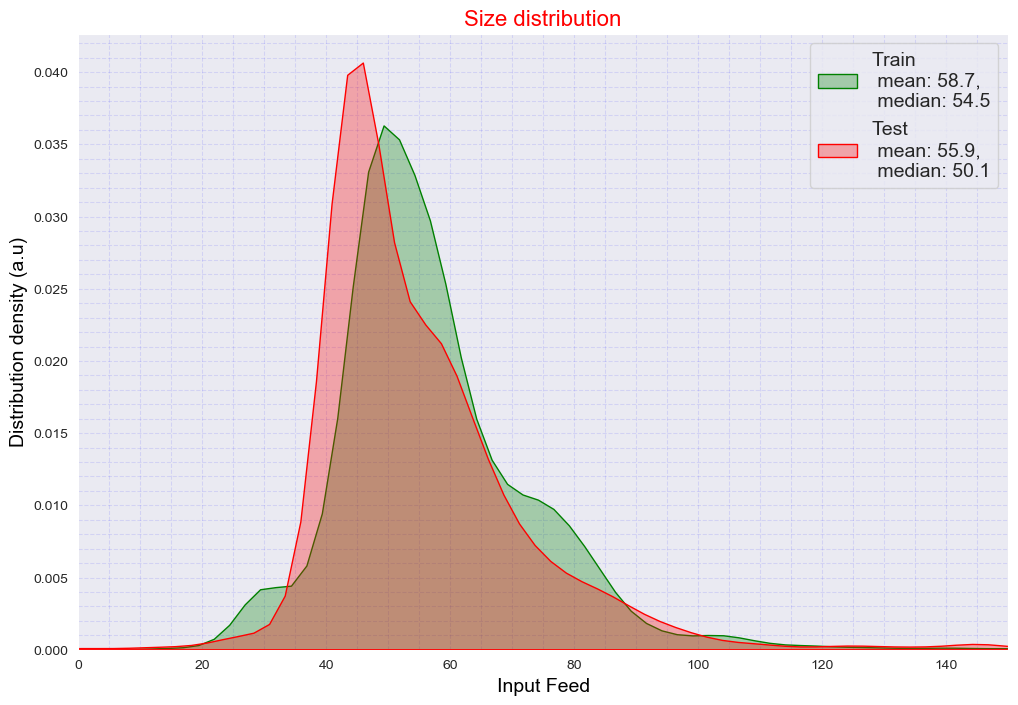

In [16]:
#Now let's show our distribution and by 
#create figure object
plt.figure(figsize=(12,8))

#plot distribution curves for each data sets conditions
sns.distplot(dist_train, hist=False, kde_kws={'shade':True, 'color':'green', 'alpha':0.3}, label=('Train \n mean: {:.3},\n median: {:.3}'.format(dist_train.mean(), dist_train.median())))
sns.distplot(dist_test, hist=False, kde_kws={'shade':True, 'color':'red', 'alpha':0.3}, label=('Test \n mean: {:.3},\n median: {:.3}'.format(dist_test.mean(), dist_test.median())))

#customize the figure
plt.title('Size distribution', fontsize=16, color='r')
plt.xlabel('Input Feed', fontsize=14, color='k')
plt.ylabel('Distribution density (a.u)', fontsize=14, color='k')
plt.xlim(0, 150) #there are some extreme values, we don't need to show them for now
plt.legend(fontsize=14)
plt.grid(b=True, which='both', color='b', linestyle='--', alpha=0.1)
plt.minorticks_on()
plt.show()

>Conclusion: From our density distribution graph, we see that we have **mean** particle size of training data **58.7** and the **mean** particle size of testing data was **55.9**. If we compare those mean values we can say that they are a little bit different, but general distribution of particle sizes are similar for two datasets.

### Step 2.3. 
**Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.**

In [17]:
#Creating our variables

gold_upd['total.raw.feed'] = gold_upd[['rougher.input.feed_ag',
                               'rougher.input.feed_pb',
                               'rougher.input.feed_au',
                               'rougher.output.tail_sol']].sum(axis=1)

gold_upd['total.roug.con'] = gold_upd[['rougher.output.concentrate_ag',
                               'rougher.output.concentrate_pb',
                               'rougher.output.concentrate_sol',
                               'rougher.output.concentrate_au']].sum(axis=1)

gold_upd['total.final.con'] = gold_upd[['final.output.concentrate_ag',
                                        'final.output.concentrate_pb',
                                        'final.output.concentrate_sol',
                                        'final.output.concentrate_sol']].sum(axis=1)


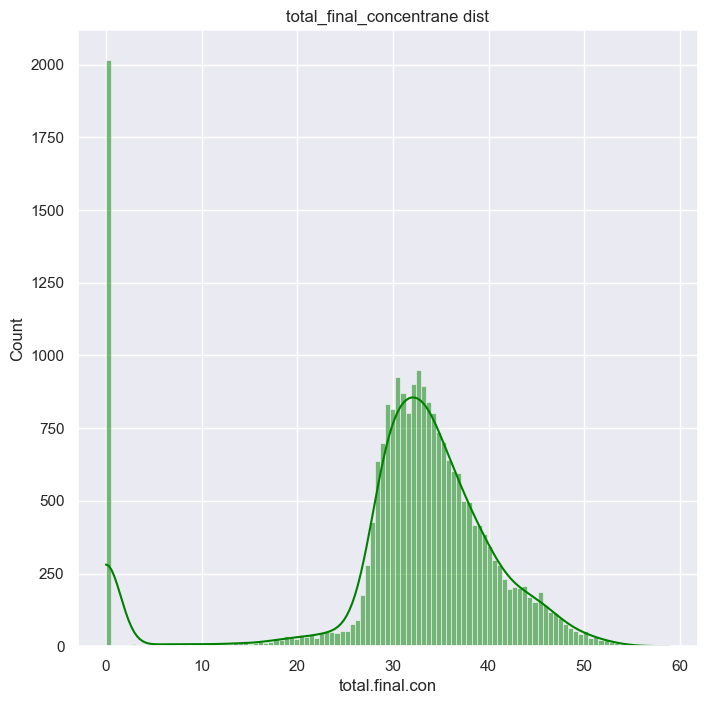

In [18]:
#Plotting first variable distribution
sns.set(style='darkgrid',font_scale=1.25)
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(data=gold_upd['total.final.con'],color='green',kde=True)
plt.title('total_final_concentrane dist');

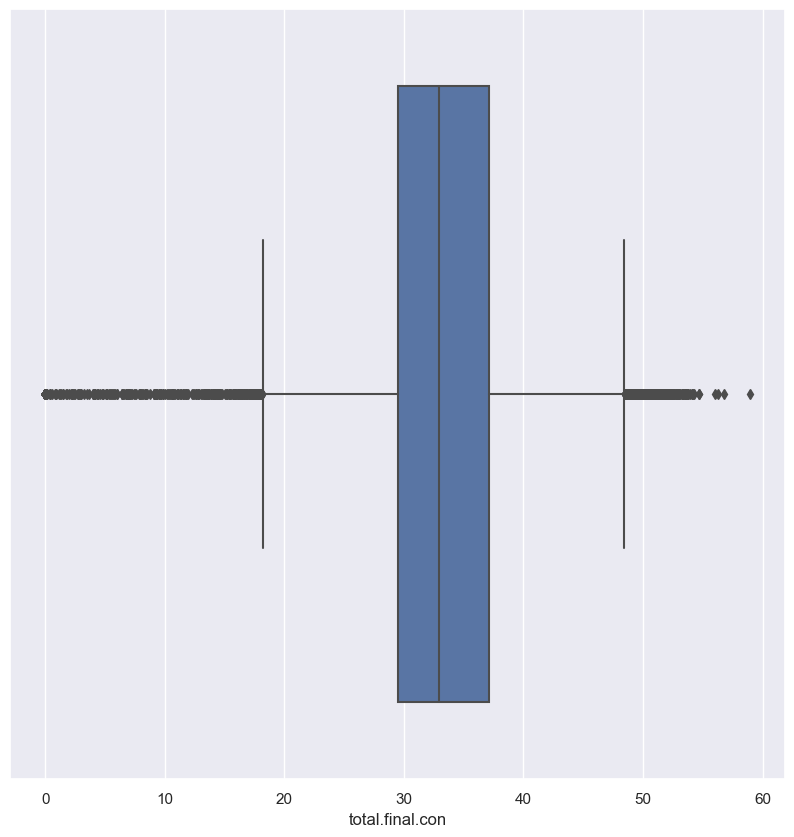

In [19]:
#Providing deeper analyzing by boxplot 
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(gold_upd['total.final.con']);

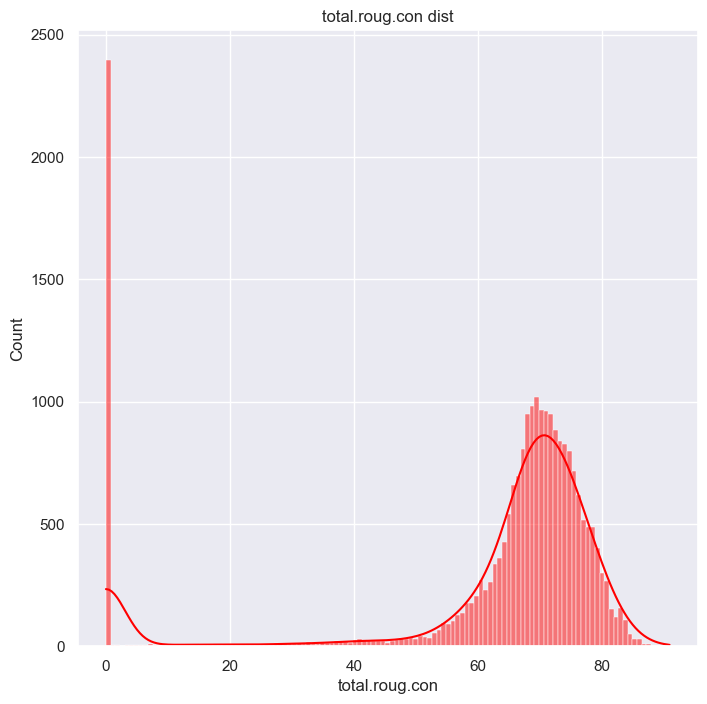

In [20]:
#Second variable distribution
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(gold_upd['total.roug.con'],color='red',kde=True)
plt.title('total.roug.con dist');

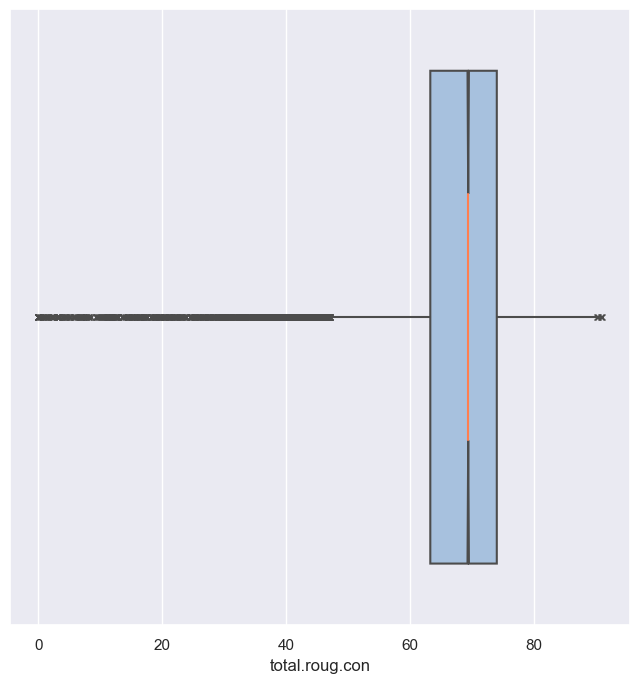

In [21]:
sns.boxplot(
    gold_upd['total.roug.con'],
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
);

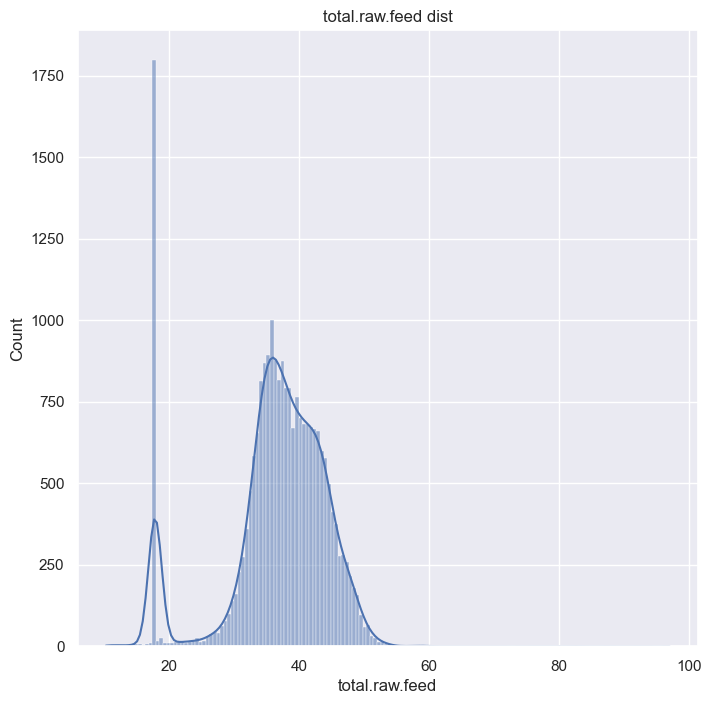

In [22]:
#And the last one variable
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(gold_upd['total.raw.feed'],kde=True)
plt.title('total.raw.feed dist');

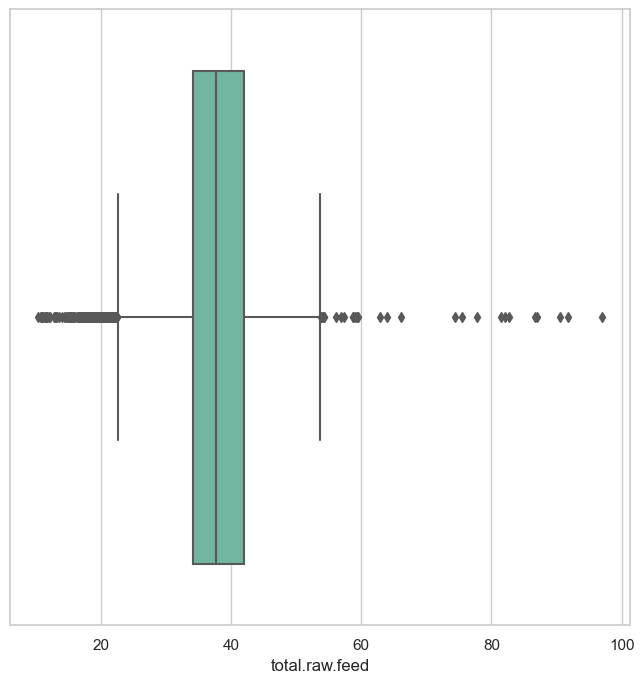

In [23]:

sns.set(style="whitegrid")
sns.boxplot(gold_upd['total.raw.feed'],
                 palette="Set2",
                dodge=True);

>Conclusion: From our histograms, we can see that we have a lot of values equal to 0  and outliers which can bring us wrong misleading and our model evaluation will be incorrect. That is why I propose to remove all anomaly values that are equal to 0.

In [24]:
#Let's remove all an anomaly values that we will provide better work for our model
anomaly_values = gold_upd[(gold_upd['total.raw.feed'] == 0) |\
            (gold_upd['total.roug.con'] == 0) |\
             (gold_upd['total.final.con'] == 0)].index


test_rows_drop = []
train_rows_drop = []

for i in anomaly_values:
    if i in test_gold_upd.index:
        test_rows_drop.append(i)
    elif i in train_gold_upd.index:
        train_rows_drop.append(i)
        


print('We dropped around {:.2%} of our train data'.format(len(train_rows_drop)/len(train_gold_upd)))       
print('We dropped around {:.2%} of our test data'.format(len(test_rows_drop)/len(test_gold_upd)))       

We dropped around 9.76% of our train data
We dropped around 9.29% of our test data


In [25]:
# drop all rows with total conc equal to 0
train_gold_upd.drop(train_rows_drop, inplace=True)
test_gold_upd.drop(test_rows_drop, inplace=True)

### Step 3. Build the model

**Step 3.1. Write a function to calculate the final sMAPE value**

In [26]:
#function to calcualte sMAPE score for predicted and actual values
def calc_metric(y, y_pred):
    smape = 1/len(y) *np.sum(np.abs(y - y_pred)*2*100/((np.abs(y) + np.abs(y_pred))))
    return smape



#Calculation final_sMAPE
def calc_metric_final(rough,final):
    final_sMAPE = 0.25 * rough + 0.75 * final
    return final_sMAPE

#convert it to sklearn function so it can be directly attached to CV scoring parameter
my_scorer=make_scorer(calc_metric, greater_is_better=False)

**Step 3.2.Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.**

- In this step, I propose to work with **LinearRegression**, **Decision Tree Regression**, and **Random Forest Regression** models. But first, we will need to standardize our features because we see that our features have different scales, that means if one feature will lies in the range from 0 to 10 and another from 0 to 100 then the algorithm will find the features with the biggest range to be more important. 

In [27]:
#Assigned our variables
features_final = test_gold_upd.columns.tolist()
features_rougher= [x for x in features_final if 'rougher' in x.split('.')]

print(len(features_final))
print()
print(len(features_rougher))

52

22


In [28]:
#Our rougher Train features
X_train_rog = train_gold_upd[features_rougher].reset_index(drop=True)
Y_train_rog = train_gold_upd['rougher.output.recovery'].reset_index(drop=True)

#Our rougher Test Features
X_test_rog = gold_upd.loc[test_gold_upd.index,features_rougher].reset_index(drop=True)
Y_test_rog = gold_upd.loc[test_gold_upd.index,'rougher.output.recovery'].reset_index(drop=True)


#Our Final Train features

X_train_final = train_gold_upd[features_final].reset_index(drop=True)
Y_train_final = train_gold_upd['final.output.recovery'].reset_index(drop=True)

#Our Final Test features
X_test_final = gold_upd.loc[test_gold_upd.index,features_final].reset_index(drop=True)
Y_test_final = gold_upd.loc[test_gold_upd.index,'final.output.recovery'].reset_index(drop=True)

In [29]:
print(X_train_rog.shape)
print(Y_train_rog.shape)
print(X_test_rog.shape)
print(Y_test_rog.shape)
print(X_train_final.shape)
print(Y_train_final.shape)
print(X_test_final.shape)
print(Y_test_final.shape)

(15215, 22)
(15215,)
(5312, 22)
(5312,)
(15215, 52)
(15215,)
(5312, 52)
(5312,)


- Now we can start work with our models 

In [30]:

#construct a pipeline
pipeline = Pipeline([('scaler',StandardScaler()), ('model', LinearRegression())])

#parameters need to be checkec here we used only three different algorithms
params = [{'model': [RandomForestRegressor(n_estimators = 200, max_depth=10, random_state=12345)]},
         {'model': [LinearRegression()]},
         {'model':[DecisionTreeRegressor(max_depth=20, random_state=12345)]}]

#construct a grid to search best algorithm
grid_r = GridSearchCV(pipeline, param_grid = params, cv=5, n_jobs = -1, scoring = my_scorer)

#train each model using 5 cross_validation steps
grid_r.fit(X_train_rog, Y_train_rog)


#display results by ranking best to worst
results_r = pd.DataFrame(grid_r.cv_results_)
results_r = results_r.sort_values('rank_test_score')
results_r

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.024199,0.006676,0.003800,0.000749,LinearRegression(),{'model': LinearRegression()},-9.052663,-7.863460,-4.615472,-5.025009,-8.916903,-7.094701,1.906580,1
0,34.544354,5.001904,0.049600,0.005609,"RandomForestRegressor(max_depth=10, n_estimato...","{'model': RandomForestRegressor(max_depth=10, ...",-9.302171,-7.351085,-5.887166,-5.126879,-8.751310,-7.283722,1.602175,2
2,0.457432,0.023591,0.003601,0.001020,"DecisionTreeRegressor(max_depth=20, random_sta...","{'model': DecisionTreeRegressor(max_depth=20, ...",-12.798388,-13.883890,-8.365958,-6.707233,-10.979603,-10.547014,2.679234,3


In [31]:
# The same operations as previous but for the final set
#train each model using 5 cross_validation steps
#construct a grid to search best algorithm
grid_f = GridSearchCV(pipeline, param_grid = params, cv=5, n_jobs = -1, scoring = my_scorer)
grid_f.fit(X_train_final, Y_train_final)


#display results by ranking best to worst
results_f = pd.DataFrame(grid_r.cv_results_)
results_f = results_r.sort_values('rank_test_score')
results_f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.024199,0.006676,0.003800,0.000749,LinearRegression(),{'model': LinearRegression()},-9.052663,-7.863460,-4.615472,-5.025009,-8.916903,-7.094701,1.906580,1
0,34.544354,5.001904,0.049600,0.005609,"RandomForestRegressor(max_depth=10, n_estimato...","{'model': RandomForestRegressor(max_depth=10, ...",-9.302171,-7.351085,-5.887166,-5.126879,-8.751310,-7.283722,1.602175,2
2,0.457432,0.023591,0.003601,0.001020,"DecisionTreeRegressor(max_depth=20, random_sta...","{'model': DecisionTreeRegressor(max_depth=20, ...",-12.798388,-13.883890,-8.365958,-6.707233,-10.979603,-10.547014,2.679234,3


- After we have done all calculations can say that our best model is "LinearRegression". Let's start working with our model **LinearRegression**

 **Step 3.3. Final model training and evaluation using test set**

In [35]:
#Starting working with our Linear Regression algorithm for rougher data sets

model = LinearRegression()

#Finding predictions values for final set
model_f = model.fit(X_train_final,Y_train_final)

predictions_final = pd.Series(model_f.predict(X_test_final), index=Y_test_final.index)


#Finding predictions values for roguegh set


model_r = model.fit(X_train_rog,Y_train_rog)

predictions_rog = pd.Series(model_r.predict(X_test_rog), index=Y_test_rog.index)




Coefficients:  [ 9.69936524e-02 -1.54442518e-01  9.87463619e-01 -7.05883348e-01
  4.91692772e-03 -7.59159249e-04  8.79266651e-03 -8.38356299e-03
 -1.29176980e-02  1.00306042e-02 -3.04229535e-03 -6.81796525e-03
 -5.85822922e-01 -2.08038768e+00 -9.22659821e-03 -9.59933910e-03
 -1.14461229e-01  1.13957557e+00 -1.69277556e-01 -8.17634341e-01
 -8.49373023e-02  2.17170157e+00  2.13723371e-03 -3.13676173e-03
  6.27377121e-03  1.56628687e-02 -6.52322256e-03  9.13793870e-03
 -8.64303483e-03  6.94836895e-03 -1.12977205e-02 -2.67609580e-02
  1.58168460e-02  6.32074035e-03  2.04874345e-01 -9.43847232e-04
 -9.55510968e-02 -1.52380103e-02  9.16273380e-02 -1.05766977e-02
 -1.64535705e-01  6.75963954e-03  2.96794364e-01  9.09686277e-03
  1.01430531e-01 -9.04360224e-03  6.11299898e-03 -1.02227466e-02
 -1.45746049e-01  3.44488368e-04 -2.95359074e-02 -9.34274565e-03]

Variance score: -0.053058204650828555


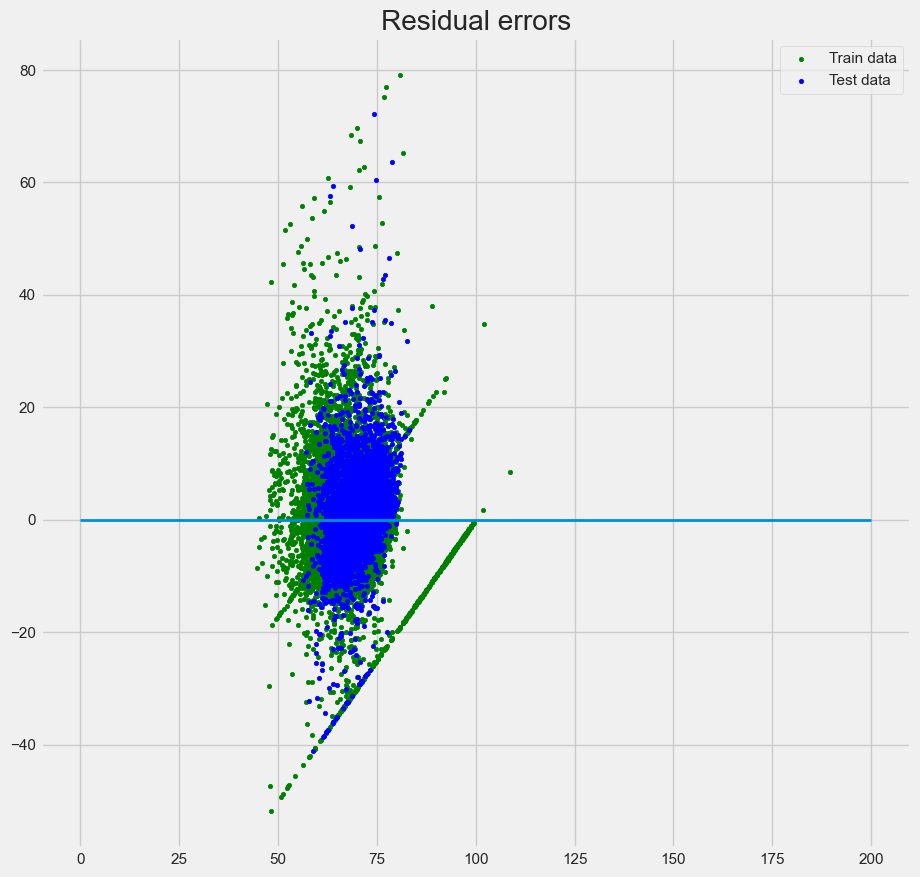

In [42]:
model.fit(X_train_final,Y_train_final)

# regression coefficients
print('Coefficients: ', model_f.coef_)
print()
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model_f.score(X_test_final, Y_test_final)))
 
# plot for residual error
plt.figure(figsize=(10,10))
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(model_f.predict(X_train_final),
            model_f.predict(X_train_final) - Y_train_final,
            color="green", s=10,
            label='Train data')
 
# plotting residual errors in test data
plt.scatter(model_f.predict(X_test_final),
            model_f.predict(X_test_final) - Y_test_final,
            color="blue", s=10,
            label='Test data')
 
# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=200, linewidth=2)
 
# plotting legend
plt.legend(loc='upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()


In [40]:
#Calculating our Final sMAPE

def calc_metric_final(rough,final):
    final_sMAPE = 0.25 * rough + 0.75 * final
    return final_sMAPE

rough = calc_metric(Y_test_rog,predictions_rog )
final = calc_metric(Y_test_final, predictions_final)


print('sMAPE score for rough set: {:.3}'.format(rough))
print('sMAPE score for final set: {:.3}'.format(final))
print('the final sMAPE score is {:.3}'.format(calc_metric_final(rough,final)))

sMAPE score for rough set: 4.72
sMAPE score for final set: 7.94
the final sMAPE score is 7.13


> Conclusion:

- 3.1 Three different algorithms were tested (LinearRegression, RandomForestRegressor, and DecisionTreeRegressor) using the cross_validation technique. After we made the calculation we found which of our models predict with the highest rate of accuracy or with the smallest number of **MAE**

- 3.2 LinearRegression were chosen as the best model with its sMAPE score for rougher and final output recoveries was equal to 4.72 and 7.94. respectively. 

- 3.3 The LinearRegression model as described above was trained with the whole training dataset and tested with the testing dataset. Ultimately, the final sMAPE value is equal to 7.13!

### Overall Conclusion:
- 1.1 Three data files have been successfully loaded. The source file (`gold`) has **22716 rows and 86 columns**. It was observed that the testing file (`test_gold`) was obtained from two different time periods of the source file and `test_gold` has **5856 rows, 52 columns**. The rest of the source file was used for the preparation of the training file (`train_gold`) with **16860 rows, 86 columns**.

- 1.2 There were missing values in all data files, these missing values were filled using **mean values of training dataset**. 

- 1.3 Several columns were not present in the testing file, however, when we check these columns, we found that they were intentionally removed. Because these columns have values that will cause data leakage for our future models.



- 2.1 It was observed that the **concentration of gold (Au) increased at each stage of purification**. In the final output stage, the concentration of **gold reached around 40**. Lead (Pb) also follows the same trend, however, the final concentration is just around 9. But, for the silver (Ag), the concentration increased first and then dropped, where at the final stage its concentration was around 5.

- 2.2 **Particle size distribution of raw feed of training and testing** data sets compared by visualizing density plots. It was observed that they have a **similar distribution**, even though their mean and median values differ slightly.

- 2.3 Finally we have checked the total concentration of substances at each stage and visualized their distribution. Surprisingly, it was found that there were a lot of rows with a total concentration equal to zero. For the sake of not putting more biases into our data, we decided to **drop all rows (in training and testing datasets) when the total concentration is equal to zero**. Consequently, **above 9% of rows were dropped** from training and testing datasets.


- 3.1 Three different algorithms were tested (**LinearRegression, RandomForestRegressor, and DecisionTreeRegressor) using the cross_validation technique**. 

- 3.2 **LinearRegression** were chosen as the **best model** with its sMAPE score for rougher and final output recoveries was equal to 4.72 and 7.94 respectively. 

- 3.3 **Ultimately, the final sMAPE value is equal to 7.13!**